In [ ]:
pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Library to dataset
import opendatasets as od
import os
import zipfile
import numpy as np

# Surpress Warnings
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# library visualization
import matplotlib.pyplot as plt

# Library Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.xception import Xception
# Others
import shutil
import random

Load-Dataset

In [ ]:
# Download dataset
od.download('https://www.kaggle.com/datasets/faudyanurul/potato')

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: faudyanurul
Your Kaggle Key: ··········


100%|██████████| 185M/185M [00:02<00:00, 85.5MB/s]


In [ ]:
# Load dataset
print("==========================Training Data====================")
train_data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato/Potato/train",
    label_mode="categorical",
    class_names= ['Potato healthy', 'Potato leaf early blight', 'Potato leaf late blight'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)
print("==========================Validation Data====================")
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    "potato/Potato/valid",
    label_mode="categorical",
    class_names= ['Potato healthy', 'Potato leaf early blight', 'Potato leaf late blight'],
    color_mode="rgb",
    batch_size=1,
    image_size=(256, 256),
    shuffle=True,
    seed=123
)

==========================Training Data====================
Found 5907 files belonging to 3 classes.
==========================Validation Data====================
Found 1442 files belonging to 3 classes.


In [ ]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(rescale = 1.0/256.)
test_datagen  = ImageDataGenerator(rescale = 1.0/256.)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory("potato/Potato/train",
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory("potato/Potato/valid",
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 5907 images belonging to 3 classes.
Found 1442 images belonging to 3 classes.


List-Resource

In [ ]:
# Check GPU
!nvidia-smi

Tue May 30 14:36:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W /  70W |    389MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices("GPU")
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Xception_1

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Xception_model1_Potato_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
Xception_model = tf.keras.models.Sequential([
    # Xception Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Max Pooling Layer
    tf.keras.layers.GlobalMaxPooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(3, activation='softmax') 
  ])


# Compile Model
Xception_model.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model.summary()

83683744/83683744 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_max_pooling2d (Globa  (None, 2048)             0         
 lMaxPooling2D)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,386,795
Trainable params: 21,332,267
Non

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_1 = Xception_model.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.2191 - accuracy: 0.9289
Epoch 1: val_accuracy improved from -inf to 0.86963, saving model to Xception_model1_Potato_Based_Non_Augmented


296/296 [==============================] - 169s 397ms/step - loss: 0.2191 - accuracy: 0.9289 - val_loss: 1.2703 - val_accuracy: 0.8696 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.0865 - accuracy: 0.9678
Epoch 2: val_accuracy improved from 0.86963 to 0.96879, saving model to Xception_model1_Potato_Based_Non_Augmented


296/296 [==============================] - 121s 410ms/step - loss: 0.0865 - accuracy: 0.9678 - val_loss: 0.1273 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.0506 - accuracy: 0.9770
Epoch 3: val_accuracy did not improve from 0.96879
296/296 [==============================] - 97s 326ms/step - loss: 0.0506 - accuracy: 0.9770 - val_loss: 0.1942 - val_accuracy: 0.9487 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9859
Epoch 4: val_accuracy improved from 0.96879 to 0.99376, saving model to Xception_model1_Potato_Based_Non_Augmented


296/296 [==============================] - 119s 403ms/step - loss: 0.0351 - accuracy: 0.9859 - val_loss: 0.0169 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 5/100
296/296 [==============================] - ETA: 0s - loss: 0.0999 - accuracy: 0.9677
Epoch 5: val_accuracy did not improve from 0.99376
296/296 [==============================] - 97s 328ms/step - loss: 0.0999 - accuracy: 0.9677 - val_loss: 0.0393 - val_accuracy: 0.9875 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - ETA: 0s - loss: 0.0708 - accuracy: 0.9751
Epoch 6: val_accuracy did not improve from 0.99376
296/296 [==============================] - 97s 326ms/step - loss: 0.0708 - accuracy: 0.9751 - val_loss: 0.0528 - val_accuracy: 0.9896 - lr: 0.0010
Epoch 7/100
296/296 [==============================] - ETA: 0s - loss: 0.0362 - accuracy: 0.9851
Epoch 7: val_accuracy improved from 0.99376 to 0.99515, saving model to Xception_model1_Potato_Based_Non_Augmented


296/296 [==============================] - 122s 413ms/step - loss: 0.0362 - accuracy: 0.9851 - val_loss: 0.0125 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 8/100
296/296 [==============================] - ETA: 0s - loss: 0.0584 - accuracy: 0.9788
Epoch 8: val_accuracy did not improve from 0.99515
296/296 [==============================] - 97s 328ms/step - loss: 0.0584 - accuracy: 0.9788 - val_loss: 0.0169 - val_accuracy: 0.9917 - lr: 0.0010
Epoch 9/100
296/296 [==============================] - ETA: 0s - loss: 0.0233 - accuracy: 0.9892
Epoch 9: val_accuracy did not improve from 0.99515
296/296 [==============================] - 97s 327ms/step - loss: 0.0233 - accuracy: 0.9892 - val_loss: 0.0144 - val_accuracy: 0.9951 - lr: 0.0010
Epoch 10/100
296/296 [==============================] - ETA: 0s - loss: 0.0627 - accuracy: 0.9795
Epoch 10: val_accuracy improved from 0.99515 to 0.99584, saving model to Xception_model1_Potato_Based_Non_Augmented


296/296 [==============================] - 118s 398ms/step - loss: 0.0627 - accuracy: 0.9795 - val_loss: 0.0135 - val_accuracy: 0.9958 - lr: 0.0010
Epoch 11/100
296/296 [==============================] - ETA: 0s - loss: 0.0382 - accuracy: 0.9844
Epoch 11: val_accuracy did not improve from 0.99584
296/296 [==============================] - 99s 334ms/step - loss: 0.0382 - accuracy: 0.9844 - val_loss: 0.0511 - val_accuracy: 0.9868 - lr: 0.0010
Epoch 12/100
296/296 [==============================] - ETA: 0s - loss: 0.0330 - accuracy: 0.9870
Epoch 12: val_accuracy did not improve from 0.99584

Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
296/296 [==============================] - 97s 327ms/step - loss: 0.0330 - accuracy: 0.9870 - val_loss: 0.0209 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 13/100
296/296 [==============================] - ETA: 0s - loss: 0.0190 - accuracy: 0.9917
Epoch 13: val_accuracy did not improve from 0.99584
296/296 [====================

296/296 [==============================] - 124s 421ms/step - loss: 0.0135 - accuracy: 0.9934 - val_loss: 0.0144 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 16/100
296/296 [==============================] - ETA: 0s - loss: 0.0117 - accuracy: 0.9937
Epoch 16: val_accuracy did not improve from 0.99653
296/296 [==============================] - 97s 326ms/step - loss: 0.0117 - accuracy: 0.9937 - val_loss: 0.0171 - val_accuracy: 0.9965 - lr: 1.0000e-04
Epoch 17/100
296/296 [==============================] - ETA: 0s - loss: 0.0104 - accuracy: 0.9944
Epoch 17: val_accuracy did not improve from 0.99653

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
296/296 [==============================] - 97s 326ms/step - loss: 0.0104 - accuracy: 0.9944 - val_loss: 0.0185 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 18/100
296/296 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 0.9961
Epoch 18: val_accuracy did not improve from 0.99653
296/296 [========

Text(0.5, 1.0, 'Training and validation loss DIY Model')

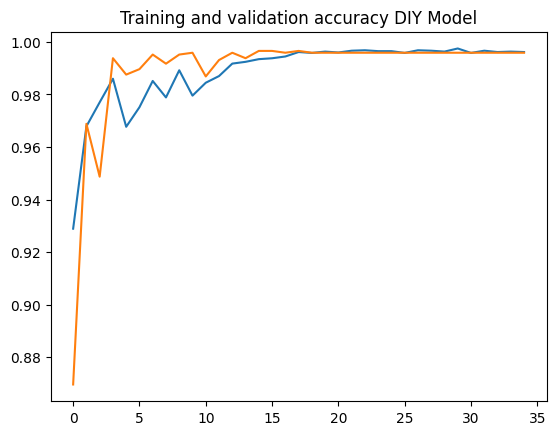

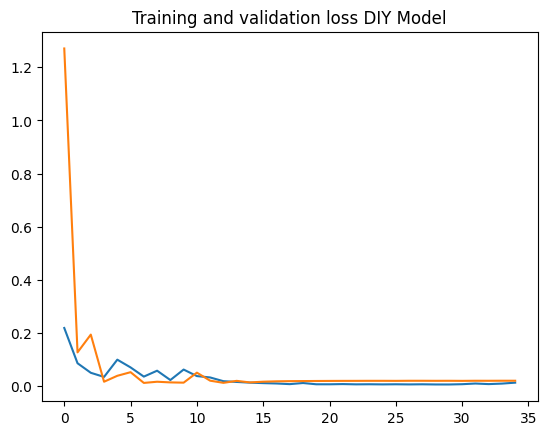

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_1.history['accuracy' ]
val_acc  = history_Xception_model_1.history['val_accuracy' ]
loss     = history_Xception_model_1.history['loss' ]
val_loss = history_Xception_model_1.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

In [ ]:
!zip -r /content/Xception_model1_Potato_Based_Non_Augmented.zip /content/Xception_model1_Potato_Based_Non_Augmented

  adding: content/Xception_model1_Potato_Based_Non_Augmented/ (stored 0%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/variables/variables.index (deflated 77%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/saved_model.pb (deflated 92%)
  adding: content/Xception_model1_Potato_Based_Non_Augmented/keras_metadata.pb (deflated 96%)


xception_2

In [ ]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Xception_model2_Potato_Based_Non_Augmented", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=20, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [ ]:
# Define DIY Model
Xception_model_2 = tf.keras.models.Sequential([
    # Xception121 Layer
    Xception(include_top=False,weights='imagenet',input_shape=(224, 224, 3)),
    # Global Average Pooling Layer
    tf.keras.layers.GlobalAveragePooling2D(),
    # Drop Out Layer
    tf.keras.layers.Dropout(0.2),
    # 256 neuron hidden layer
    tf.keras.layers.Dense(256, activation='relu'),
    # Output
    tf.keras.layers.Dense(3, activation='softmax') 
  ])


# Compile Model
Xception_model_2.compile(loss='categorical_crossentropy',optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy']) 

# Model Summary
Xception_model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21,386,795
Trainable params: 21,332,267
Non-trainable params: 54,528
_____________________________________

In [ ]:
# Define the number of epochs
num_epochs = 100

# Train the model
history_Xception_model_2 = Xception_model_2.fit(train_generator, epochs=num_epochs, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/100
296/296 [==============================] - ETA: 0s - loss: 0.0466 - accuracy: 0.9790
Epoch 1: val_accuracy did not improve from 0.99168
296/296 [==============================] - 98s 331ms/step - loss: 0.0466 - accuracy: 0.9790 - val_loss: 1.0665 - val_accuracy: 0.9528 - lr: 0.0010
Epoch 2/100
296/296 [==============================] - ETA: 0s - loss: 0.0605 - accuracy: 0.9780
Epoch 2: val_accuracy did not improve from 0.99168
296/296 [==============================] - 98s 329ms/step - loss: 0.0605 - accuracy: 0.9780 - val_loss: 0.0495 - val_accuracy: 0.9813 - lr: 0.0010
Epoch 3/100
296/296 [==============================] - ETA: 0s - loss: 0.0467 - accuracy: 0.9777
Epoch 3: val_accuracy did not improve from 0.99168
296/296 [==============================] - 101s 341ms/step - loss: 0.0467 - accuracy: 0.9777 - val_loss: 0.2622 - val_accuracy: 0.9348 - lr: 0.0010
Epoch 4/100
296/296 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9805
Epoch 4: val_accu

296/296 [==============================] - 124s 418ms/step - loss: 0.0443 - accuracy: 0.9834 - val_loss: 0.0147 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 6/100
296/296 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9846
Epoch 6: val_accuracy improved from 0.99307 to 0.99376, saving model to Xception_model2_Potato_Based_Non_Augmented


296/296 [==============================] - 124s 418ms/step - loss: 0.0389 - accuracy: 0.9846 - val_loss: 0.0822 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 7/100
296/296 [==============================] - ETA: 0s - loss: 0.0502 - accuracy: 0.9824
Epoch 7: val_accuracy did not improve from 0.99376
296/296 [==============================] - 97s 327ms/step - loss: 0.0502 - accuracy: 0.9824 - val_loss: 0.0200 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 8/100
296/296 [==============================] - ETA: 0s - loss: 0.0380 - accuracy: 0.9832
Epoch 8: val_accuracy did not improve from 0.99376
296/296 [==============================] - 96s 326ms/step - loss: 0.0380 - accuracy: 0.9832 - val_loss: 0.0180 - val_accuracy: 0.9938 - lr: 0.0010
Epoch 9/100
296/296 [==============================] - ETA: 0s - loss: 0.0282 - accuracy: 0.9876
Epoch 9: val_accuracy did not improve from 0.99376
296/296 [==============================] - 96s 326ms/step - loss: 0.0282 - accuracy: 0.9876 - val_loss: 0.9070 - v

296/296 [==============================] - 123s 417ms/step - loss: 0.0262 - accuracy: 0.9898 - val_loss: 0.0177 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 12/100
296/296 [==============================] - ETA: 0s - loss: 0.0181 - accuracy: 0.9932
Epoch 12: val_accuracy did not improve from 0.99584
296/296 [==============================] - 95s 320ms/step - loss: 0.0181 - accuracy: 0.9932 - val_loss: 0.0165 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 13/100
296/296 [==============================] - ETA: 0s - loss: 0.0174 - accuracy: 0.9919
Epoch 13: val_accuracy did not improve from 0.99584
296/296 [==============================] - 96s 324ms/step - loss: 0.0174 - accuracy: 0.9919 - val_loss: 0.0153 - val_accuracy: 0.9958 - lr: 1.0000e-04
Epoch 14/100
296/296 [==============================] - ETA: 0s - loss: 0.0341 - accuracy: 0.9910
Epoch 14: val_accuracy did not improve from 0.99584
296/296 [==============================] - 97s 326ms/step - loss: 0.0341 - accuracy: 0.9910 - va

296/296 [==============================] - 123s 416ms/step - loss: 0.0273 - accuracy: 0.9939 - val_loss: 0.0202 - val_accuracy: 0.9965 - lr: 1.0000e-05
Epoch 20/100
296/296 [==============================] - ETA: 0s - loss: 0.0103 - accuracy: 0.9954
Epoch 20: val_accuracy did not improve from 0.99653

Epoch 20: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
296/296 [==============================] - 95s 319ms/step - loss: 0.0103 - accuracy: 0.9954 - val_loss: 0.0207 - val_accuracy: 0.9958 - lr: 1.0000e-05
Epoch 21/100
296/296 [==============================] - ETA: 0s - loss: 0.0090 - accuracy: 0.9961
Epoch 21: val_accuracy did not improve from 0.99653
296/296 [==============================] - 96s 324ms/step - loss: 0.0090 - accuracy: 0.9961 - val_loss: 0.0209 - val_accuracy: 0.9958 - lr: 1.0000e-06
Epoch 22/100
296/296 [==============================] - ETA: 0s - loss: 0.0111 - accuracy: 0.9961
Epoch 22: val_accuracy did not improve from 0.99653
296/296 [========

Text(0.5, 1.0, 'Training and validation loss DIY Model')

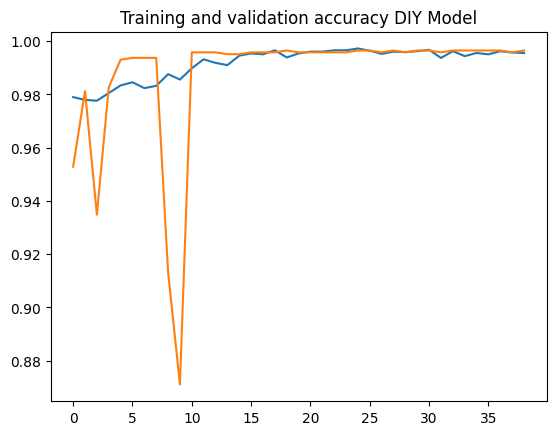

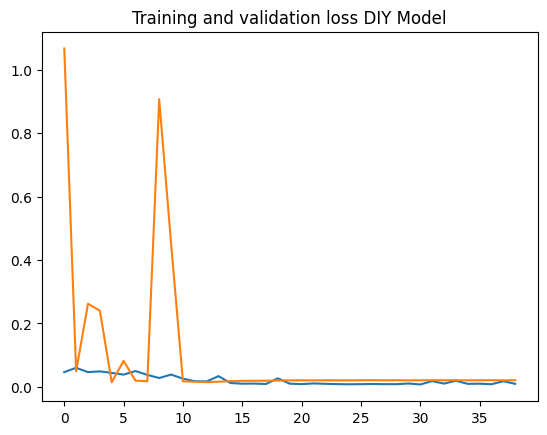

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history_Xception_model_2.history['accuracy' ]
val_acc  = history_Xception_model_2.history['val_accuracy' ]
loss     = history_Xception_model_2.history['loss' ]
val_loss = history_Xception_model_2.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  (epochs, acc )
plt.plot  (epochs, val_acc )
plt.title ('Training and validation accuracy DIY Model')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  (epochs, loss)
plt.plot  (epochs, val_loss)
plt.title ('Training and validation loss DIY Model')

In [ ]:

!zip -r /content/Xception_model2_Potato_Based_Non_Augmented.zip /content/Xception_model2_Potato_Based_Non_Augmented

  adding: content/Xception_model2_Potato_Based_Non_Augmented/ (stored 0%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/variables/ (stored 0%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/variables/variables.index (deflated 77%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/assets/ (stored 0%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/fingerprint.pb (stored 0%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/saved_model.pb (deflated 92%)
  adding: content/Xception_model2_Potato_Based_Non_Augmented/keras_metadata.pb (deflated 96%)
